# Binary Classification

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 42

In [4]:
lemmas = pd.read_csv('../data/lemmas.csv')
lemmas

,book_poem_id,lemmas
0,1_0001-0000-0000-0001-0000,"[('tvůj', 'P'), ('loď', 'N'), ('jít', 'V'), ('..."
1,1_0001-0001-0000-0001-0000,"[('už', 'D'), ('míza', 'N'), ('naplňovat', 'V'..."
2,1_0001-0001-0000-0002-0000,"[('už', 'D'), ('jaro', 'N'), ('výskat', 'V'), ..."
3,1_0001-0001-0000-0003-0000,"[('teď', 'D'), ('slunce', 'N'), ('projít', 'V'..."
4,1_0001-0001-0000-0004-0000,"[('skála', 'N'), ('nebetyčný', 'A'), ('shluk',..."
...,...,...
66423,1689_0001-0000-0000-0026-0000,"[('u', 'R'), ('altán', 'N'), ('bílý', 'A'), ('..."
66424,1689_0001-0000-0000-0027-0000,"[('nad', 'R'), ('tůně', 'N'), ('honit', 'V'), ..."
66425,1689_0001-0000-0000-0028-0000,"[('podle', 'R'), ('cesta', 'N'), ('hloh', 'N')..."
66426,1689_0001-0000-0000-0029-0000,"[('na', 'R'), ('lesní', 'A'), ('stráň', 'N'), ..."


In [5]:
annotations = pd.read_csv('../data/poem_value_save.csv')
annotations

,book_poem_id,poem_id,book_id,id_topic,value,name
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,1,-1,Dětství/mateřství/rodičovství
1,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,2,-1,Domov
2,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,3,-1,Exotika/cestovatelství
3,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,4,-1,Chudoba/útisk
4,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,9,-1,Náboženství/víra
...,...,...,...,...,...,...
27154,1675_0001-0009-0000-0015-0002,0001-0009-0000-0015-0002,1675,26,-1,Město
27155,1675_0001-0009-0000-0015-0002,0001-0009-0000-0015-0002,1675,27,-1,Venkov
27156,1675_0001-0009-0000-0015-0002,0001-0009-0000-0015-0002,1675,28,-1,Národ/vlast
27157,1675_0001-0009-0000-0015-0002,0001-0009-0000-0015-0002,1675,29,-1,Historie


In [6]:
annotations_1 = annotations[annotations.value == 1].reset_index(drop=True)
annotations_1

,book_poem_id,poem_id,book_id,id_topic,value,name
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,Práce
1,2_0001-0000-0000-0008-0000,0001-0000-0000-0008-0000,2,9,1,Náboženství/víra
2,3_0001-0003-0000-0012-0000,0001-0003-0000-0012-0000,3,9,1,Náboženství/víra
3,7_0001-0000-0000-0065-0000,0001-0000-0000-0065-0000,7,20,1,"Umění/literatura, poezie/tvorba"
4,8_0001-0000-0000-0004-0000,0001-0000-0000-0004-0000,8,30,1,Sebereflexe/vnitřní život
...,...,...,...,...,...,...
917,1675_0001-0005-0000-0028-0000,0001-0005-0000-0028-0000,1675,14,1,Příroda
918,1675_0001-0005-0000-0042-0000,0001-0005-0000-0042-0000,1675,30,1,Sebereflexe/vnitřní život
919,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,12,1,Politika/společnost
920,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,26,1,Město


In [7]:
annotations_lemmas = pd.merge(annotations_1, lemmas, on='book_poem_id', how='left')
annotations_lemmas

,book_poem_id,poem_id,book_id,id_topic,value,name,lemmas
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,Práce,"[('chuť', 'N'), ('k', 'R'), ('práce', 'N'), ('..."
1,2_0001-0000-0000-0008-0000,0001-0000-0000-0008-0000,2,9,1,Náboženství/víra,"[('truchlit', 'V'), ('když', 'J'), ('rána', 'N..."
2,3_0001-0003-0000-0012-0000,0001-0003-0000-0012-0000,3,9,1,Náboženství/víra,"[('srdce', 'N'), ('Páně', 'A'), ('velechrám', ..."
3,7_0001-0000-0000-0065-0000,0001-0000-0000-0065-0000,7,20,1,"Umění/literatura, poezie/tvorba","[('náš', 'P'), ('lid', 'N'), ('ty', 'P'), ('ch..."
4,8_0001-0000-0000-0004-0000,0001-0000-0000-0004-0000,8,30,1,Sebereflexe/vnitřní život,"[('mít', 'V'), ('plout', 'V'), ('loď', 'N'), (..."
...,...,...,...,...,...,...,...
917,1675_0001-0005-0000-0028-0000,0001-0005-0000-0028-0000,1675,14,1,Příroda,"[('do', 'R'), ('duše', 'N'), ('rozjásaný', 'A'..."
918,1675_0001-0005-0000-0042-0000,0001-0005-0000-0042-0000,1675,30,1,Sebereflexe/vnitřní život,"[('ó', 'I'), ('smutný', 'A'), ('srdce', 'N'), ..."
919,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,12,1,Politika/společnost,"[('jít', 'V'), ('mimo', 'R'), ('nalíčený', 'A'..."
920,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,26,1,Město,"[('jít', 'V'), ('mimo', 'R'), ('nalíčený', 'A'..."


# Filter the data

- Filter out all POS but Nouns (N), Adjectives (A) and Verbs (V)

- Filter out frequent (stop)words that does not carry any extra semantic information

In [8]:
stopwords = ['mít', 'jít', 'být', 'dát', 'moci', 'chtít']

In [9]:
%%time

lemmas_filtered_column = []

# extract lemmas with N, A or V POS tag
for index, poem in annotations_lemmas.iterrows():
    if index % 1000 == 0:
        print(index, end=' ')
    
    lemmas_filtered_poem = []
    lemmas_poem = literal_eval(poem['lemmas'])
    for lemma_pos in lemmas_poem:
        lemma, pos = lemma_pos
        if pos in ['N', 'A', 'V'] and lemma not in stopwords:
            lemmas_filtered_poem.append(lemma)
    lemmas_filtered_column.append(lemmas_filtered_poem)

0 CPU times: user 951 ms, sys: 13 ms, total: 964 ms
Wall time: 968 ms


In [10]:
annotations_lemmas['lemmas_filtered'] = lemmas_filtered_column
annotations_lemmas

,book_poem_id,poem_id,book_id,id_topic,value,name,lemmas,lemmas_filtered
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,Práce,"[('chuť', 'N'), ('k', 'R'), ('práce', 'N'), ('...","[chuť, práce, milý, dítě, bůh, práce, síla, ďá..."
1,2_0001-0000-0000-0008-0000,0001-0000-0000-0008-0000,2,9,1,Náboženství/víra,"[('truchlit', 'V'), ('když', 'J'), ('rána', 'N...","[truchlit, rána, bolný, lidský, zloba, usoudit..."
2,3_0001-0003-0000-0012-0000,0001-0003-0000-0012-0000,3,9,1,Náboženství/víra,"[('srdce', 'N'), ('Páně', 'A'), ('velechrám', ...","[srdce, Páně, velechrám, svatý, skvít, záře, k..."
3,7_0001-0000-0000-0065-0000,0001-0000-0000-0065-0000,7,20,1,"Umění/literatura, poezie/tvorba","[('náš', 'P'), ('lid', 'N'), ('ty', 'P'), ('ch...","[lid, chránit, stánek, chudý, slavíček, smutný..."
4,8_0001-0000-0000-0004-0000,0001-0000-0000-0004-0000,8,30,1,Sebereflexe/vnitřní život,"[('mít', 'V'), ('plout', 'V'), ('loď', 'N'), (...","[plout, loď, daleký, vodní, pláň, modrý, dálka..."
...,...,...,...,...,...,...,...,...
917,1675_0001-0005-0000-0028-0000,0001-0005-0000-0028-0000,1675,14,1,Příroda,"[('do', 'R'), ('duše', 'N'), ('rozjásaný', 'A'...","[duše, rozjásaný, slavný, zachytit, zář, korun..."
918,1675_0001-0005-0000-0042-0000,0001-0005-0000-0042-0000,1675,30,1,Sebereflexe/vnitřní život,"[('ó', 'I'), ('smutný', 'A'), ('srdce', 'N'), ...","[smutný, srdce, zatoulat, bledý, soumrak, vůně..."
919,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,12,1,Politika/společnost,"[('jít', 'V'), ('mimo', 'R'), ('nalíčený', 'A'...","[nalíčený, žena, zrak, hořet, tmít, obočí, šíj..."
920,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,26,1,Město,"[('jít', 'V'), ('mimo', 'R'), ('nalíčený', 'A'...","[nalíčený, žena, zrak, hořet, tmít, obočí, šíj..."


In [11]:
annotations_lemmas = annotations_lemmas.drop(['name'], axis=1)

In [12]:
annotations_lemmas.head(1)

,book_poem_id,poem_id,book_id,id_topic,value,lemmas,lemmas_filtered
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,"[('chuť', 'N'), ('k', 'R'), ('práce', 'N'), ('...","[chuť, práce, milý, dítě, bůh, práce, síla, ďá..."


# TFIDF classification

## one-against-all strategy

In [13]:
annotations_lemmas['preprocessed_text'] = annotations_lemmas['lemmas_filtered'].apply(lambda x: ' '.join(x))
annotations_lemmas.head()

,book_poem_id,poem_id,book_id,id_topic,value,lemmas,lemmas_filtered,preprocessed_text
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,"[('chuť', 'N'), ('k', 'R'), ('práce', 'N'), ('...","[chuť, práce, milý, dítě, bůh, práce, síla, ďá...",chuť práce milý dítě bůh práce síla ďáblův pad...
1,2_0001-0000-0000-0008-0000,0001-0000-0000-0008-0000,2,9,1,"[('truchlit', 'V'), ('když', 'J'), ('rána', 'N...","[truchlit, rána, bolný, lidský, zloba, usoudit...",truchlit rána bolný lidský zloba usoudit ruka ...
2,3_0001-0003-0000-0012-0000,0001-0003-0000-0012-0000,3,9,1,"[('srdce', 'N'), ('Páně', 'A'), ('velechrám', ...","[srdce, Páně, velechrám, svatý, skvít, záře, k...",srdce Páně velechrám svatý skvít záře kříž zna...
3,7_0001-0000-0000-0065-0000,0001-0000-0000-0065-0000,7,20,1,"[('náš', 'P'), ('lid', 'N'), ('ty', 'P'), ('ch...","[lid, chránit, stánek, chudý, slavíček, smutný...",lid chránit stánek chudý slavíček smutný hlas ...
4,8_0001-0000-0000-0004-0000,0001-0000-0000-0004-0000,8,30,1,"[('mít', 'V'), ('plout', 'V'), ('loď', 'N'), (...","[plout, loď, daleký, vodní, pláň, modrý, dálka...",plout loď daleký vodní pláň modrý dálka štěstí...


In [14]:
targets = [1,  2,  3,  4,  9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [15]:
def grid_search(estimator, param_grid, X, y, cv=5, scoring='accuracy'):
    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator, param_grid, cv=cv, n_jobs=-1, scoring=scoring)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X, y)
    
    return grid_search.best_params_, grid_search.best_score_

In [16]:
results = dict()

In [17]:
f1_macro_scorer = make_scorer(f1_score, average='macro')

In [18]:
scoring = 'accuracy'

In [19]:
# Create k-fold cross-validation object
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [20]:
def create_plot(fpr, tpr, roc_auc, target):
    plt.rcParams.update({'font.size': 10})

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    ax.plot(fpr, tpr, label='ROC', color='darkorange')

    ax.fill_between(fpr, tpr, alpha=0.2, label='AUC ={:.3f}'.format(roc_auc))

    ax.axis('square')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0, 1], [0, 1], "--", color = 'grey', label='random prediction')
    ax.legend()

    ax.set_title(label=f'ROC curve for clasification of {target}')
    plt.savefig(f'../img/ROC_binary_topic_{target}_oversampled.png', dpi=400, bbox_inches='tight', pad_inches=0)

    plt.show()

In [21]:
model_name = 'MLP_TFIDF'

In [29]:
def binary_class(data, target):
    print('******************************************************')
    print('Target: ', target)
    X = data[['preprocessed_text']]
    y = pd.DataFrame()
    y['target'] = data[['id_topic']] == target
    print(y['target'].value_counts())
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print(len(X_train), len(X_test))
    
    # oversampling
    #ros = RandomOverSampler(random_state=42)
    #X_train_sampled, y_train_sampled = ros.fit_resample(X_train, y_train)
    
    # TFIDF vectorization
    vectorizer_tfidf = TfidfVectorizer()
    train_X_encodings_tfidf = vectorizer_tfidf.fit_transform(X_train['preprocessed_text'])
    test_X_encodings_tfidf = vectorizer_tfidf.transform(X_test['preprocessed_text'])

    # hyperparameter tunning ??
    
    # final evaluation
    model = MLPClassifier(activation='logistic', alpha=0.001, random_state=42)
    model.fit(train_X_encodings_tfidf, y_train)
    y_pred = model.predict(test_X_encodings_tfidf)
    
    acc = accuracy_score(y_true=y_test, y_pred=y_pred)
    f1 = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
    y_score = model.predict_proba(test_X_encodings_tfidf)[:,1]
    
    # binarizace
    binar = LabelBinarizer()
    y_train = binar.fit_transform(y_train)
    y_test = binar.transform(y_test)
    
    # ROC krivka
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    #create_plot(fpr, tpr, roc_auc, target)
    
    print(acc, f1)
    
    print('******************************************************')
    
    return acc, f1, fpr, tpr, roc_auc

In [30]:
#binary_class(annotations_lemmas, 4)

In [31]:
results = dict()

for i in targets:
    results[i] = binary_class(annotations_lemmas, i)
    
print(results)

******************************************************
Target:  1
False    893
True      29
Name: target, dtype: int64
645 277
0.9602888086642599 0.48987108655616945
******************************************************
******************************************************
Target:  2
False    907
True      15
Name: target, dtype: int64
645 277
0.9819494584837545 0.49544626593806923
******************************************************
******************************************************
Target:  3
False    918
True       4
Name: target, dtype: int64
645 277
0.9963898916967509 0.49909584086799275
******************************************************
******************************************************
Target:  4
False    906
True      16
Name: target, dtype: int64
645 277
0.9819494584837545 0.49544626593806923
******************************************************
******************************************************
Target:  9
False    837
True      85
Name: target, dtype: int

In [32]:
fpr = []
tpr = []
roc_auc = []

for i in results:
    fpr.append(results[i][2])
    tpr.append(results[i][3])
    roc_auc.append(results[i][4])
    
print(fpr)

[array([0.        , 0.00373134, 0.02985075, 0.02985075, 0.03358209,
       0.03731343, 0.04477612, 0.04477612, 0.07089552, 0.07835821,
       0.11940299, 0.12313433, 0.14552239, 0.15298507, 0.21268657,
       0.21268657, 0.21641791, 0.2238806 , 0.23880597, 0.24253731,
       0.52985075, 0.52985075, 0.55597015, 0.55597015, 0.74253731,
       0.75      , 0.88432836, 0.89179104, 0.89179104, 0.89925373,
       0.90671642, 0.9141791 , 0.93656716, 0.94402985, 1.        ]), array([0.        , 0.00367647, 0.01470588, 0.01470588, 0.05147059,
       0.05147059, 0.35294118, 0.35294118, 0.48897059, 0.50367647,
       0.65441176, 0.65441176, 0.70955882, 0.71691176, 0.92647059,
       0.93382353, 0.94117647, 0.94485294, 0.97058824, 0.97794118,
       1.        ]), array([0.        , 0.00362319, 0.38043478, 0.38768116, 0.39855072,
       0.4057971 , 0.54710145, 0.54710145, 0.80434783, 0.8115942 ,
       0.81884058, 0.82608696, 0.91304348, 0.92028986, 0.98188406,
       0.98913043, 0.99275362, 1.     

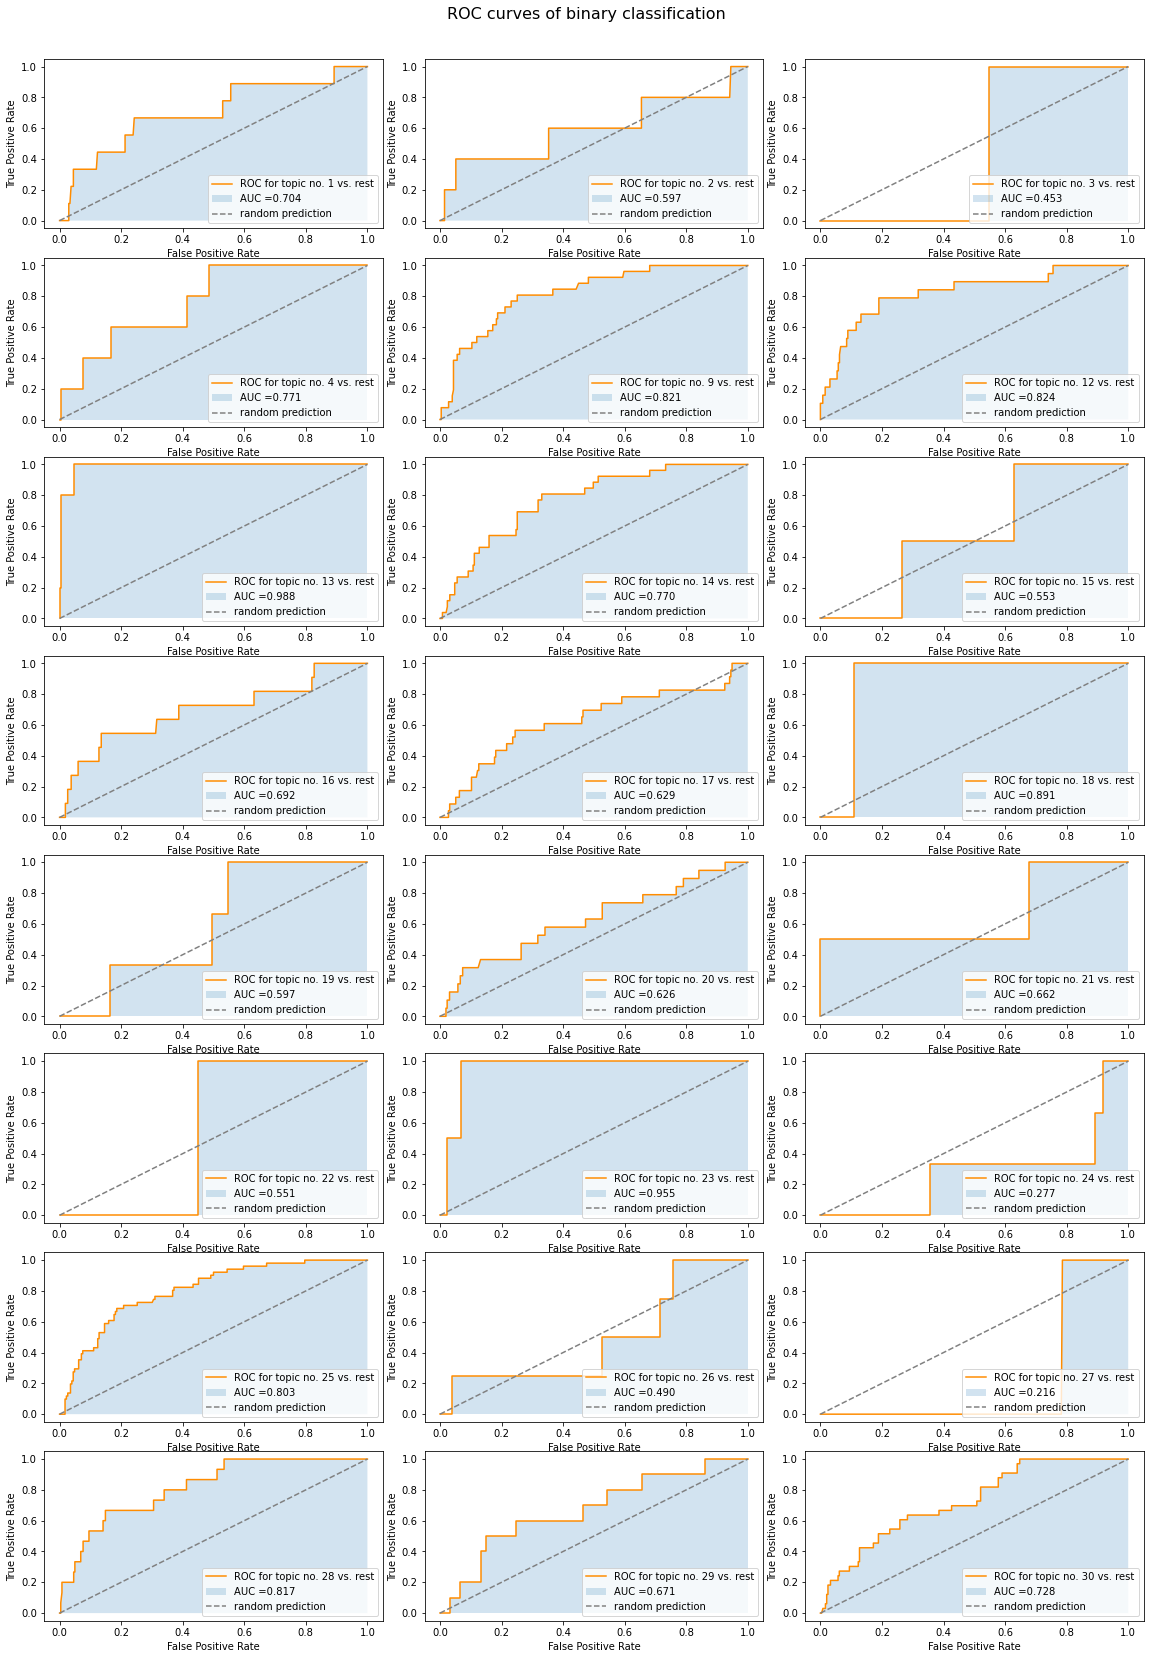

In [33]:
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(8, 3, figsize=(16, 24))
fig.tight_layout()

pos_x = 0
pos_y = 0

targets_origin = [1, 2, 3, 4, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

for x in range(24): # number of classes
    ax[pos_x, pos_y].plot(
    fpr[x],
    tpr[x],
    label=f'ROC for topic no. {targets_origin[x]} vs. rest', # start from topic 1 (indexovano od 1)
    color='darkorange',
    )
    ax[pos_x, pos_y].fill_between(fpr[x], tpr[x], alpha=0.2, label='AUC ={:.3f}'.format(roc_auc[x]))
    

    ax[pos_x, pos_y].set_xlabel('False Positive Rate')
    ax[pos_x, pos_y].set_ylabel('True Positive Rate')
    ax[pos_x, pos_y].plot([0, 1], [0, 1], "--", color = 'grey', label='random prediction')
    ax[pos_x, pos_y].legend(loc='lower right')
    

    pos_y += 1
    
    if pos_y == 3:
        pos_x += 1 
        pos_y = 0       

st = fig.suptitle(f'ROC curves of binary classification', fontsize=16)
# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.92)

plt.savefig('../img/ROC_all_classes_binary.png', dpi=400, bbox_inches='tight', pad_inches=0)

plt.show()

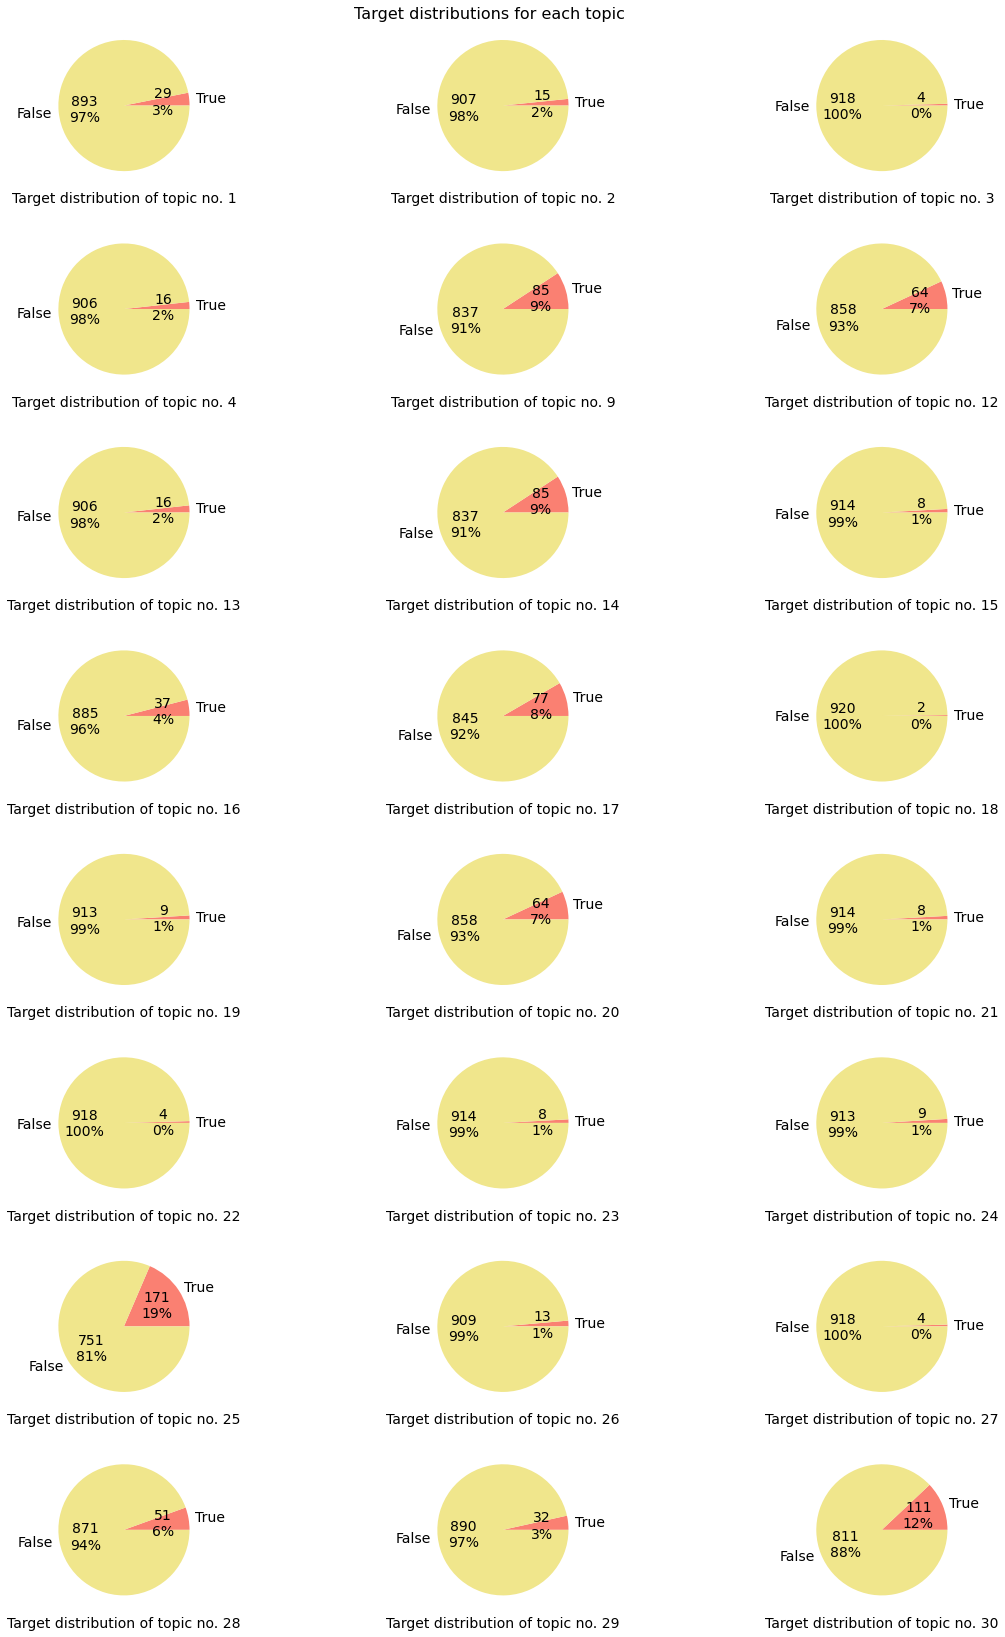

In [44]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(8, 3, figsize=(16, 24))
fig.tight_layout()

pos_x = 0
pos_y = 0

y = pd.DataFrame()
targets_origin = [1, 2, 3, 4, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

def label_function(val):
    return f'{val / 100 * len(annotations_lemmas):.0f}\n{val:.0f}%'

for x in range(24): # number of classes
    
    y['target'] = annotations_lemmas[['id_topic']] == targets_origin[x]
    true_rows = y[(y["target"] == True)]
    
    num_true_rows = len(true_rows)
    total_records = len(y)
    num_false_rows = total_records - num_true_rows
    
    ax[pos_x, pos_y].pie([num_true_rows, num_false_rows], labels = ['True', 'False'], autopct = label_function,
                        colors=['salmon', 'khaki'])

    ax[pos_x, pos_y].set_xlabel(f'Target distribution of topic no. {targets_origin[x]}')

    pos_y += 1
    
    if pos_y == 3:
        pos_x += 1 
        pos_y = 0       

st = fig.suptitle(f'Target distributions for each topic', fontsize=16)
# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.94)

plt.savefig('../img/targets_all_classes_binary.png', dpi=400, bbox_inches='tight', pad_inches=0)

plt.show()